# Content Mining Models

## Table of Contents
##### [1. Data Preprocessing and Imports](#preprocessing)
##### [2. Models](#models)
###### [2.1. Cosine Similarity](#cosine)
###### [2.2. LSI Model](#lsi)
###### [2.3. Mixture Model](#mixture)
##### [3. Interpretation and Evaluation](#interpretation_evaluation)

<a id='preprocessing'></a>
## 1. Data Preprocessing and Imports

In [76]:
import pandas as pd
import numpy as np
import sklearn

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
import nltk
import inflect
import re, string, unicodedata
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk import SnowballStemmer
from nltk.stem import LancasterStemmer, WordNetLemmatizer
import matplotlib.pyplot as plt

In [2]:
# Import functions module
%run functions.py

In [53]:
interactions_data = pd.read_csv(
        'C:/Users/d067795/OneDrive - SAP SE/Documents/Master/Semester 2/Web Mining/Project/RAW_interactions.csv')
recipes_data = pd.read_csv(
        'C:/Users/d067795/OneDrive - SAP SE/Documents/Master/Semester 2/Web Mining/Project/RAW_recipes.csv')


KeyError: 'avg_rating'

In [57]:
# Rename columns to more explanatory names
recipes_data.rename(columns={"id": "recipe_id"}, inplace=True)
interactions_data.rename(columns={"num_interactions": "date", "avg_rating": "rating"}, inplace=True)

# Fill nan
recipes_data.fillna("", inplace=True)
interactions_data.fillna("", inplace=True)

In [5]:
# Preprocess ingredients and save as String
for index, row in recipes_data.iterrows():
    ingredientlist = row['ingredients']
    ingredientlist = row['ingredients'].replace('[', '').replace(', ', '').replace(']', '').replace('and', '\'').split("\'")
    ingredientlist = list(filter(None, ingredientlist))
    ingredientlistString = ""
    for i in ingredientlist:
        ingredientlistString = ingredientlistString + i
    recipes_data.at[index, 'ingredients'] = ingredientlistString

In [8]:
# Extract keywords for free text features
get_keywords(recipes_data, "steps", "steps_keywords")
get_keywords(recipes_data, "description", "description_keywords")
get_keywords(interactions_data, "review", "review_keywords")

,user_id,recipe_id,date,rating,review_keywords
0,38094,40893,2003-02-17,4,used low fat sour cream great salt thanks shak...
1,1293707,40893,2011-12-21,5,doubled chilly fall evening great simple notic...
2,8937,44394,2002-12-01,4,used quite great whole package well worked eas...
3,126440,85009,2010-02-27,5,made everyone loved mexican topping bunko took
4,57222,85009,2011-10-01,5,made adding yum cheddar bacon topping sprinkli...
...,...,...,...,...,...
1132362,116593,72730,2003-12-09,0,fresh cranberries start making sauce cooking a...
1132363,583662,386618,2009-09-29,5,chili powder adds another dimension truly enjo...
1132364,157126,78003,2008-06-23,5,years hand hunt say enough mushrooms serve one...
1132365,53932,78003,2009-01-11,4,gravy nicely flavored well good used regular p...


In [65]:
# Merge datasets
#Average ratings
num_interactions = interactions_data.groupby("recipe_id")["date"].count()

#only consider the ratings (>0) into the mean, not the reviews w/o ratings
mean_ratings = interactions_data[interactions_data["rating"]!=0].groupby("recipe_id")["rating"].mean()

df_rmerged = recipes_data.join(num_interactions, how="left", on="recipe_id").join(mean_ratings, how="left", on="recipe_id")

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

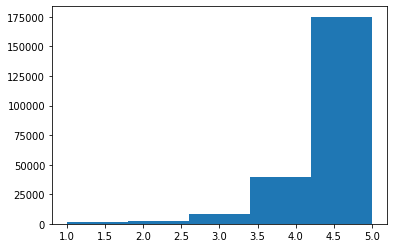

In [84]:
plt.hist(df_rmerged['rating'], bins = 5)

In [114]:
mean_ratings = df_rmerged[np.logical_not(np.isnan(df_rmerged['rating']))]
mean_ratings = mean_ratings[mean_ratings['rating']!=0]
avg_rating = sum(mean_ratings['rating']) /len(mean_ratings['rating'])
avg_rating

df_rmerged['rating'].fillna(avg_rating, inplace=True)

### NLP Preprocessing

In [115]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\d067795\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\d067795\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\d067795\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [116]:
def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_special(words):
    """Remove special signs like &*"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[-,$()#+&*]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""  
    stopwords = nltk.corpus.stopwords.words('english')
    myStopWords = []
    stopwords.extend(myStopWords)
    new_words = []
    for word in words:
        if word not in stopwords:
            new_words.append(word)
    return new_words

def to_lowercase(words):
    """Convert words to lowercase"""
    new_words=[]
    for word in words:
        new_words.append(word.lower())
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    #stemmer = SnowballStemmer('english')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize_lemmatize(words):
    words = remove_special(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = replace_numbers(words)
    words = remove_stopwords(words)
    #words = stem_words(words)
    words = lemmatize_verbs(words)
    return words

In [117]:
def get_processed(data):
    processed = pd.DataFrame(data=[],columns = ['recipe_id', 'content'])
    new_texts = []

    for i in range(0, len(sample)):
        recipe_id = sample['recipe_id'].iloc[i]
        words = nltk.word_tokenize(sample['content'].iloc[i])
        text = ' '.join(normalize_lemmatize(words))
        dfnew = pd.DataFrame([[recipe_id, text]], columns=['recipe_id', 'content'])
        new_texts.append(text)
        processed = processed.append(dfnew,ignore_index = True)

    return processed

In [118]:
helper = pd.unique(interactions_data['recipe_id'])
df_rfiltered = df_rmerged[df_rmerged.recipe_id.isin(helper)]
print(df_rmerged.shape)
df_rfiltered.shape

(231637, 14)


(231637, 14)

In [119]:
def create_input (df, column_names):
    length = len(column_names)
    df_content = df
    df_content['content'] = df.loc[:, (column_names)].apply(lambda texts: ' '.join(texts), axis=1)
    df_content.drop(columns = column_names, inplace = True)
    df_content['content']=df_content['content'].apply(lambda text: ' '.join(text.split()))
    return df_content

In [120]:
#flatten steps data
df_rfiltered.steps = df_rfiltered.loc[:, ('steps')].str.replace("\[", "").str.replace("'", "").str.replace("\]", "").str.replace(",","").copy()

#create content df
df_content = create_input(df_rfiltered[['recipe_id', 'name','description', 'steps']], ['name','description', 'steps'])

df_content.head()

C:\Users\d067795\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\d067795\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\d067795\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

,recipe_id,content
0,137739,arriba baked winter squash mexican style autum...
1,31490,a bit different breakfast pizza this recipe ca...
2,112140,all in the kitchen chili this modified version...
3,59389,"alouette potatoes this is a super easy, great ..."
4,44061,amish tomato ketchup for canning my dh's amish...


In [121]:
sample = df_content.sample(n=1000, replace=False, random_state=42)\
                 .reset_index()\
                 .drop(columns=['index'])
sample.head()

,recipe_id,content
0,94947,crab filled crescent snacks found in a crescen...
1,429010,curried bean salad serve this flavorful and re...
2,277542,delicious steak with onion marinade another i'...
3,78450,pork tenderloin with hoisin another keeper fro...
4,80012,mixed baby greens with oranges grapefruit and ...


In [122]:
processed = get_processed(sample)
processed.head()

,recipe_id,content
0,94947,crab fill crescent snack find crescent roll re...
1,429010,curry bean salad serve flavorful refresh salad...
2,277542,delicious steak onion marinade another try loo...
3,78450,pork tenderloin hoisin another keeper bonnie s...
4,80012,mix baby green oranges grapefruit avocado love...


<a id='models'></a>
## 2. Models

<a id='cosine'></a>
### 2.1. Cosine Similarity

In [134]:
def get_cos_sim_matrix(processed):
  tfidf = TfidfVectorizer(stop_words='english')
  processed['content'] = processed['content'].fillna('')
  tfidf_matrix = tfidf.fit_transform(processed['content'])
  svd = TruncatedSVD(n_components=10, random_state=42)
  tfidf_truncated = svd.fit_transform(tfidf_matrix) 
  cosine_sim = cosine_similarity(tfidf_truncated,tfidf_truncated)
  return cosine_sim

cosine_sim = get_cos_sim_matrix(processed)

In [130]:
interactions_processed = get_interaction_processed(processed, interactions_data)
interactions_processed.head()

,user_id,recipe_id,date,rating,review
0,88378,445577,2012-07-25,5,Very good - we all enjoyed this. I used just ...
1,2114486,445577,2013-07-04,3,"I&#039;d suggest using green curry paste, rath..."
2,900992,445577,2013-10-02,3,We added an extra jalapeno pepper and used Tha...
3,2503874,129377,2012-11-16,4,set up beautifully once it was completely cool...
4,247152,310201,2009-05-27,5,"This was even better than expected, especially..."


In [124]:
def get_coverage(processed, interactions, recipe, cosine_sim,k):
    interactions_processed = get_interaction_processed(processed, interactions)
    uid_sample = interactions_processed['user_id'].values
    rid_sample = interactions_processed['recipe_id'].values

    all_rids = interactions_processed['recipe_id'].unique()
    pred_rids = []

    for i in range(len(interactions_processed)):
        try:
          recipe_ids = get_recommendation_cos(processed,
                                                interactions_processed,
                                                rid_sample[i],
                                                uid_sample[i],
                                                cosine_sim,
                                                k)
          pred_rids += list(recipe_ids)
        except:
          next
    pred_bids = np.array(list(set(pred_rids)))
    return len(pred_bids)/len(all_rids)

In [131]:
uid_sample = interactions_processed['user_id'].values
rid_sample = interactions_processed['recipe_id'].values
print(uid_sample)
print(rid_sample)
predictions_cos = []
actual_cos = []
print(interactions_processed.head())
print(processed.head())

for i in range(len(interactions_processed)):
    try:
        act, pred = get_results_cos(processed,
                                    interactions_processed,
                                    recipes_data,
                                    rid_sample[i],
                                    uid_sample[i],
                                    cosine_sim,
                                    5)
        predictions_cos.append(pred)
        actual_cos.append(act)
    except:
        next

[  88378 2114486  900992 ...  428885  169430  369363]
[445577 445577 445577 ... 273409 273409 273409]
   user_id  recipe_id        date  rating  \
0    88378     445577  2012-07-25       5   
1  2114486     445577  2013-07-04       3   
2   900992     445577  2013-10-02       3   
3  2503874     129377  2012-11-16       4   
4   247152     310201  2009-05-27       5   

                                              review  
0  Very good - we all enjoyed this.  I used just ...  
1  I&#039;d suggest using green curry paste, rath...  
2  We added an extra jalapeno pepper and used Tha...  
3  set up beautifully once it was completely cool...  
4  This was even better than expected, especially...  
  recipe_id                                            content
0     94947  crab fill crescent snack find crescent roll re...
1    429010  curry bean salad serve flavorful refresh salad...
2    277542  delicious steak onion marinade another try loo...
3     78450  pork tenderloin hoisin another k

In [135]:
rmse_cos = mean_squared_error(predictions_cos, actual_cos)**0.5
mae_cos = mean_absolute_error(predictions_cos, actual_cos)
print(f'RMSE: {rmse_cos}, MAE: {mae_cos}')

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [136]:
cov_cos = get_coverage(processed, interactions_data, recipes_data, cosine_sim,5)
print(f'coverage: {cov_cos}')

coverage: 0.738


<a id='lsi'></a>
### 2.2. LSI Model

<a id='mixture'></a>
### 2.3. Mixture Model

- Improve the model fit by including another similarity measure on top of cosine similarity
- Cosine similarity used to retrive similarity of texutal features
- Euclidean distance used to enhance with similarity of numerical features
- Assumption: Distribution f is a mixture of K komponent distribution each having a mixture weight \lambda_k 
- The new similarity matrix is then a linear combination of the cosine similarity matrix and the euclidean similarity matrix that are multiplied by a factor lambda and 1-lambda
- The optimal value of lambda needs to be optimized afterwards

### 2.3.1. Overall

In [157]:
def get_mix_sim_matrix(processed, lmbda, recipes_data):
  cos_sim = get_cos_sim_matrix(processed)
  df_sub = recipes_data[['recipe_id', 'n_steps', 'minutes', 'n_ingredients']]
  df_processed = df_sub[df_sub['recipe_id'].isin(processed['recipe_id'])]\
                                                             .set_index('recipe_id')

  scaler = StandardScaler()
  X = scaler.fit_transform(df_processed)
  eucl_dis = euclidean_distances(X,X)

  eucl_sim = 1/np.exp(eucl_dis)
  mixed_sim = np.add(cos_sim*lmbda,eucl_sim*(1-lmbda)) # assume equally weighted

  return mixed_sim

In [158]:
mixed_sim = get_mix_sim_matrix(processed, 0.5, df_rfiltered)
mixed_sim.shape

(1000, 1000)

In [159]:
predictions_mix = []
actual_mix = []
for i in range(len(interactions_processed)):
  try:
    act, pred = get_results_cos(processed, 
                                interactions_processed, 
                                recipes_data, 
                                rid_sample[i], 
                                uid_sample[i], 
                                mixed_sim, 
                                5)
    predictions_mix.append(pred)
    actual_mix.append(act)
  except:
    next

In [160]:
rmse_mix = mean_squared_error(predictions_mix, actual_mix)**0.5
mae_mix = mean_absolute_error(predictions_mix, actual_mix)
print(f'RMSE: {rmse_mix}, MAE: {mae_mix}')

RMSE: 1.0518422149832958, MAE: 0.5


In [161]:
cov_mix = get_coverage(processed, interactions_data, recipes_data, mixed_sim, 5)
print(f'coverage: {cov_mix}')

coverage: 0.74


#### 2.3.2. Optimization of Parameter

In [162]:
def tuning_mix_param(lmbdas, processed, interactions_data, recipes_data):
  rmse_mix = []

  interactions_processed = get_interaction_processed(processed, interactions_data)
  uid_sample = interactions_processed['user_id'].values
  rid_sample = interactions_processed['recipe_id'].values

  for lmbda in lmbdas:
    mixed_sim = get_mix_sim_matrix(processed, lmbda, recipes_data)
    predictions_mix, actual_mix = [], []
    for i in range(len(interactions_processed)):
      try:
        act, pred = get_results_cos(processed, 
                                    interactions_processed, 
                                    recipes_data, 
                                    rid_sample[i], 
                                    uid_sample[i], 
                                    mixed_sim, 
                                    5)
        predictions_mix.append(pred)
        actual_mix.append(act)
      except:
        next
    
    rmse = mean_squared_error(predictions_mix, actual_mix)**0.5
    rmse_mix.append(rmse)
  
  return rmse_mix

In [163]:
sample_s = df_content.sample(n=1000, replace=False, random_state=42)\
                  .reset_index()\
                  .drop(columns=['index'])

processed_s = get_processed(sample_s)
lmbdas = np.linspace(0,1,5)

In [164]:
rmse_mix_tune = tuning_mix_param(lmbdas,
                                 processed_s, 
                                 interactions_data, 
                                 recipes_data)
rmse_mix_min = min(rmse_mix_tune)
rmse_mix_min_idx = rmse_mix_tune.index(rmse_mix_min)
lmbda_min = lmbdas[rmse_mix_min_idx]

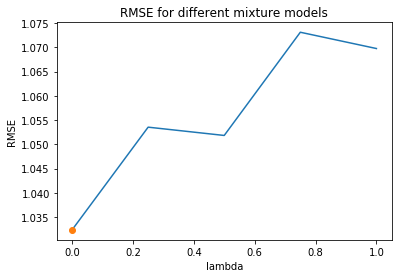

In [165]:
plt.plot(lmbdas, rmse_mix_tune)
plt.xlabel('lambda')
plt.ylabel('RMSE')
plt.title('RMSE for different mixture models')
plt.plot([lmbda_min], [rmse_mix_min], 'o')
plt.show()

<a id='interpretation_evaluation'></a>
## 3. Interpretation and Evaluation